In [4]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [5]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [6]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [7]:
df1.iloc[:, 3:]

,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


In [8]:
c=-1
P_exp=np.array(df1.iloc[:, 3:].drop('H1',axis=1))[:c]
T_exp=np.array(df1['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(14, 337235.3)

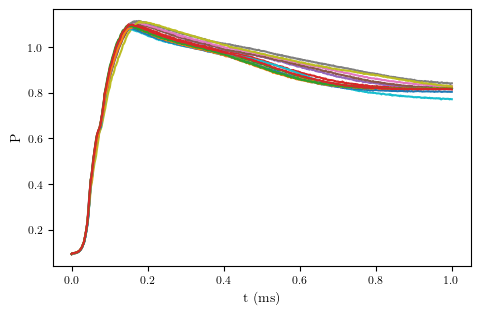

In [9]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [10]:
N_f = 500 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx0 = T_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.ones((len(xx0),1))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx0,xxd)).reshape([-1,1])
p_train = np.concatenate((uu0,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-10 12:18:37.881015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 12:18:38.282103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3962 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5


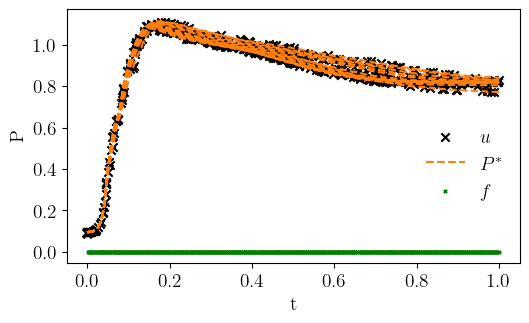

In [11]:
colors = plt.cm.tab10.colors
plt.scatter(T_u_train, p_train, marker='x', color='black',label='$u$')

plt.plot(T_star[:len(T_exp)],P_star_tf[:len(T_exp)], color = colors[1], linestyle='--', label='$P^*$')

for i in range(1, N_exp):
    plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star_tf[i*len(T_exp):(i+1)*len(T_exp)], color = colors[1], linestyle='--')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), marker='x', s=5, color='green',label='$f$')

plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.6))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# plt.savefig('../Img/413/u.png')
# plt.savefig('../Img/413/u.pdf')
# plt.savefig('../Img/413/u.svg')
# plt.savefig('figures/P_phi.pdf')
plt.show()


In [12]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi, b_phi, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]
        p=tf.exp(lnp)
        s=tf.exp(lns)
        m=tf.exp(lnv[0:1])
        
        phi=net(s, W_phi, b_phi)

    p_t = tape1.gradient(p, t) 
    s_t = tape1.gradient(s, t) 
    f_p = p_t - phi*p
    f_s = s_t + m[0]*p*s
    
    return f_p, f_s


#@tf.function()
# @tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, p_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_r, lambda_b, lambda_0, lnv])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        lns=u_nn[:,1:2]
        p_nn=tf.exp(lnp)
        f_p, f_s = net_f(t_f, W_p, b_p, W_phi, b_phi, lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        s_00=tf.exp(lns_0)


        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r*f_p) 
        loss_fs = tf.square(lambda_r*f_s) 
        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_fp), tf.reduce_mean(loss_fs)



layers = [1, 50, 50, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 50, 50, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)
lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 1), (1, -1)), dtype=tf.float32) 

In [13]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/40)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer2)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer2)


In [14]:
Nmax=10**5


while it <= Nmax:
    if it<10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv)
    elif it< 2*10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv)
    else:
        loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi, b_phi, T_u_train_tf, p_train_tf, T_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 562679.5625
Data loss is: 188251.21875
Physicial loss of p is: 1.0417205095291138
Physicial loss of s is: 7.21088171005249
Iteration is: 10
Total loss is: 76581.9296875
Data loss is: 63453.9296875
Physicial loss of p is: 0.005967005621641874
Physicial loss of s is: 0.001963466638699174
Iteration is: 20
Total loss is: 56977.93359375
Data loss is: 56694.3828125
Physicial loss of p is: 0.023919571191072464
Physicial loss of s is: 0.8636357188224792
Iteration is: 30
Total loss is: 57928.97265625
Data loss is: 57622.90234375
Physicial loss of p is: 0.06347516924142838
Physicial loss of s is: 1.8544389009475708
Iteration is: 40
Total loss is: 55034.58984375
Data loss is: 55015.1328125
Physicial loss of p is: 0.00582632003352046
Physicial loss of s is: 2.779489755630493
Iteration is: 50
Total loss is: 51766.62890625
Data loss is: 51690.06640625
Physicial loss of p is: 0.019483115524053574
Physicial loss of s is: 3.414337396621704
Iteration is: 60
Total loss is: 

In [15]:
Nmax=len(loss)

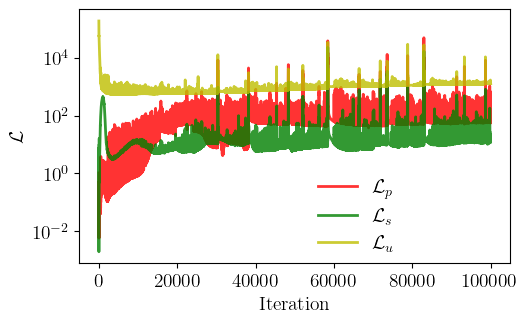

In [16]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(it, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(0.77, 0.4))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/413/Loss_split.png')
plt.savefig('../Img/413/Loss_split.pdf')
plt.savefig('../Img/413/Loss_split.svg')
plt.show()

In [17]:
lnv[0], tf.exp(lnv[0]), #lnv[1], tf.exp(lnv[1])


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.9251597], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([18.637201], dtype=float32)>)

In [18]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]
p=tf.exp(lnp)
s=tf.exp(lns)
phi_pred = predict(s, W_phi, b_phi)
phi_s=np.array(p*s*tf.exp(lnv[0]))


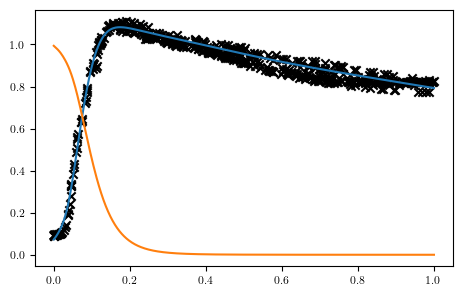

In [19]:
plt.plot(T_star_tf, p, label='Prediction P')
plt.plot(T_star_tf, s, label='Prediction S')

# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')



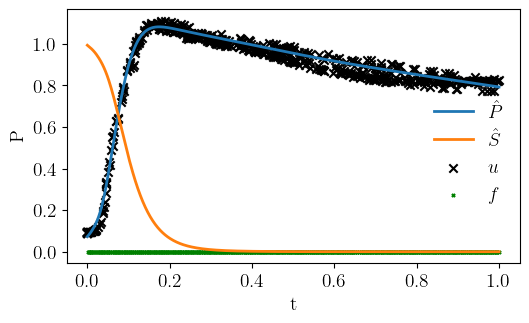

In [20]:
# plt.plot(T_star_tf, p, label='Prediction P')
# plt.plot(T_star_tf, s, label='Prediction S')

# # for i in range(N_exp):
# #     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

# plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')


plt.plot(T_star_tf, p, linestyle='-',linewidth=2, label='$\hat{P}$')
plt.plot(T_star_tf, s, linestyle='-',linewidth=2, label='$\hat{S}$')
plt.scatter(T_u_train, p_train, marker='x', color='black',label='$u$')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), marker='x', s=5, color='green',label='$f$')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/413/Result.png')
plt.savefig('../Img/413/Result.pdf')
plt.savefig('../Img/413/Result.svg')
plt.show()

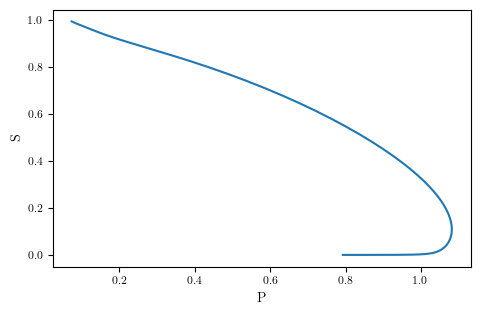

In [21]:
plt.plot(p, s)
plt.xlabel('P')
plt.ylabel('S')
# plt.savefig('figures/P_phi.pdf')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


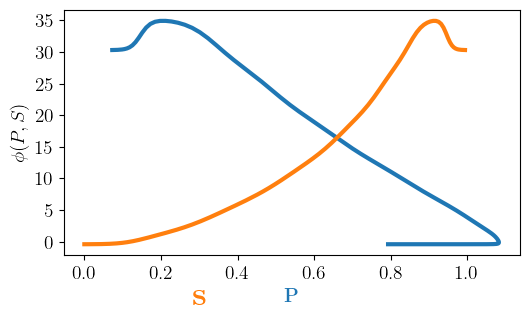

In [22]:
plt.plot(p, phi_pred,linewidth=3)
plt.plot(s, phi_pred, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel(r'$\mathbf{P}$', fontsize=14, color=colors[0])
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color=colors[1], ha='center', transform=plt.gca().transAxes)

plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/413/Result_phi.png')
plt.savefig('../Img/413/Result_phi.pdf')
plt.savefig('../Img/413/Result_phi.svg')
plt.show()

In [23]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S_int=np.zeros(Nt)

dt=0.0001

T_int[0]=0
# P_int[0]=np.mean(uu1) #Initial conditions
P_int[0]=np.array(p[0]) #Initial conditions
S_int[0]=np.array(s[0]) #Initial conditions


for i in range(1,Nt):

    # PS=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    S_i=tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)
    P_int[i]=P_int[i-1]+predict(S_i , W_phi, b_phi)*P_int[i-1]*dt
    # P_int[i]=max(P_int[i],0)
    S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]* tf.exp(lnv[0])*dt
    # P_int[i]=max(S_int[i],0)
    T_int[i]=T_int[i-1]+dt

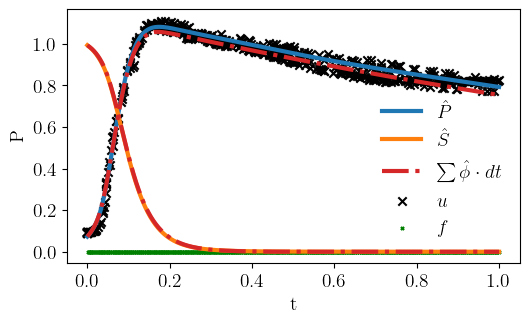

In [24]:
# plt.plot(T_star_tf, p, label='Prediction P')
# plt.plot(T_star_tf, s, label='Prediction S')

# # for i in range(N_exp):
# #     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

# plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')


plt.plot(T_star_tf, p, linestyle='-',linewidth=3, label='$\hat{P}$')
plt.plot(T_star_tf, s, linestyle='-',linewidth=3, label='$\hat{S}$')
plt.plot(T_int, P_int, linestyle='-.',linewidth=3, color=colors[3], label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_int, S_int, linestyle='-.',linewidth=3, color=colors[3])


plt.scatter(T_u_train, p_train, marker='x', color='black',label='$u$')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), marker='x', s=5, color='green',label='$f$')

# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/413/Result_int.png')
plt.savefig('../Img/413/Result_int.pdf')
plt.savefig('../Img/413/Result_int.svg')
plt.show()

# Symbolic Regresion

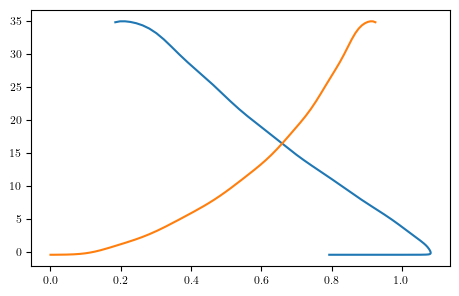

In [25]:
c=15
d=-1
plt.plot(p[c:d], np.array(phi_pred)[c:d])
plt.plot(s[c:d], np.array(phi_pred)[c:d])


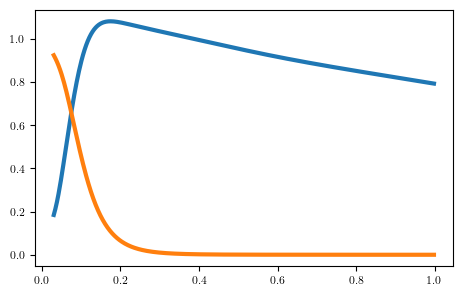

In [26]:
plt.plot(T_star_tf[c:d], p[c:d], linestyle='-',linewidth=3, label='$\hat{P}$')
plt.plot(T_star_tf[c:d], s[c:d], linestyle='-',linewidth=3, label='$\hat{S}$')

In [27]:
max_cols_phi=tf.reshape(tf.math.reduce_max(phi_pred[c:d], axis=0), [-1, 1])
min_cols_phi = tf.reshape(tf.math.reduce_min(phi_pred[c:d], axis=0), [-1, 1])
phi_scaled = (phi_pred[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)


In [28]:
# Create and train the PySR model
model_phi= PySRRegressor(
    niterations=700,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=1,
    # constraints={"constant": 0},
    maxsize=30,
    progress=True  # Show progress during training
)

In [29]:
# Create and train the PySR model
model_phi= PySRRegressor(
    niterations=700,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    # weights=np.array(p[c:d,0]),
    elementwise_loss="myloss(x, y, w) = w*(x - y)^2",
    # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,

    # select_k_features=1,
    # constraints={"constant": 0},
    maxsize=30,
    progress=True  # Show progress during training
)

In [30]:
# Fit phi
# model_phi.fit(tf.concat([p[c:d], s[c:d]],1), phi_scaled)
# model_phi.fit(s[c:d], phi_scaled[:,0], weights=(p[c:d]/((p[c:d]-0.2)**2+0.2)+1)[:,0])
model_phi.fit(s[c:d], phi_scaled[:,0], weights=(4*(p[c:d]-0.5)**2+1)[:,0])


print(model_phi )

c:\Users\u256063\AppData\Local\anaconda3\envs\tf2.8\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.160e+05
Head worker occupation: 22.5%
Progress: 501 / 10500 total iterations (4.771%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.330e-03  1.594e+01  y = x₀
3           6.580e-04  9.421e-01  y = x₀ * x₀
5           5.933e-05  1.203e+00  y = (x₀ * x₀) * 1.1872
7           3.767e-05  2.271e-01  y = ((x₀ * 1.2923) + -0.079601) * x₀
9           2.515e-05  2.021e-01  y = x₀ * ((0.9345 + (x₀ * 0.31632)) * x₀)
11          2.385e-05  2.644e-02  y = x₀ * ((1.0332 + (x₀ * (0.23395 * x₀))) * x₀)
13          2.381e-05  7.563e-04  y = ((x₀ + 0.012416) + (0.2593 * ((x₀ * x₀) * x₀))) * x₀
15          2.376e-05  1.177e-03  y = ((((inv(x₀, 2.8976) * x₀) * x₀) + 0.0084881) + x₀) * x₀
17          2.305e-05  1.514e-02  y = (x₀ + (((x₀ * (((x₀ * -0.77707) * x₀) + x₀)) * x₀) * x₀)) ...
                                  * x₀
19          2.239e-05  

In [31]:
import sympy


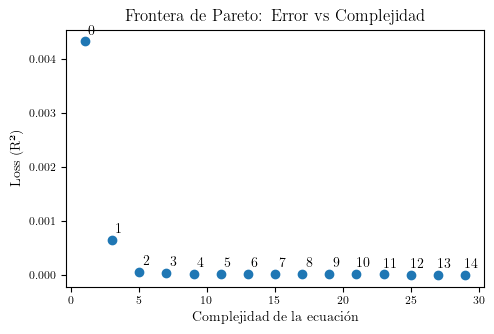

In [32]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

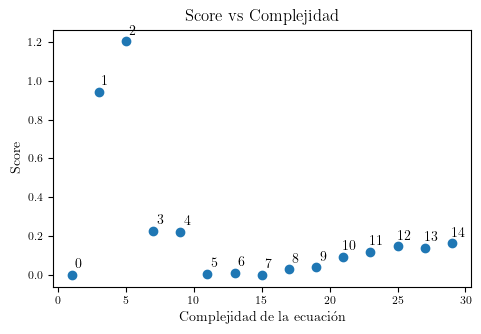

In [33]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [34]:
equations_df


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.004330,0.000000,x0,x0,PySRFunction(X=>x0)
1,3,0.000658,0.942077,x0 * x0,x0*x0,PySRFunction(X=>x0*x0)
2,5,0.000059,1.203028,(x0 * 1.1871959) * x0,x0*1.1871959*x0,PySRFunction(X=>x0*1.1871959*x0)
3,7,0.000038,0.227101,((1.2922645 * x0) + -0.07955853) * x0,x0*(1.2922645*x0 - 0.07955853),PySRFunction(X=>x0*(1.2922645*x0 - 0.07955853))
4,9,0.000024,0.222237,"-5.8913155 * inv(x0 * x0, -5.6277323)",-5.8913155*x0**2/(x0*x0 - 5.6277323),PySRFunction(X=>-5.8913155*x0**2/(x0*x0 - 5.62...
5,11,0.000024,0.006343,x0 * (x0 * (1.033203 + (0.23397018 * (x0 * x0)))),x0*x0*(0.23397018*x0*x0 + 1.033203),PySRFunction(X=>x0*x0*(0.23397018*x0*x0 + 1.03...
6,13,0.000023,0.010941,"((0.7355804 * (x0 * x0)) + inv(x0, 0.8829467))...",x0*(0.7355804*x0*x0 + x0/(x0 + 0.8829467)),PySRFunction(X=>x0*(0.7355804*x0*x0 + x0/(x0 +...
7,15,0.000023,0.000920,"(x0 * (inv(x0, 0.88043) + (0.73492306 * (x0 * ...",x0*(0.73492306*x0*x0 + x0/(x0 + 0.88043)) - 0....,PySRFunction(X=>x0*(0.73492306*x0*x0 + x0/(x0 ...
8,17,0.000022,0.028400,"((((x0 + (-0.40965116 * inv(-1.8913103, x0))) ...",x0*x0*(x0*(x0 - (-1)*0.774777458314948/(x0 - 1...,PySRFunction(X=>x0*x0*(x0*(x0 - (-1)*0.7747774...
9,19,0.000020,0.038631,(x0 * (((x0 * ((1.369854 + (-1.1968502 * x0)) ...,x0*x0*(x0*x0*x0*x0*(1.369854 - 1.1968502*x0) +...,PySRFunction(X=>x0*x0*(x0*x0*x0*x0*(1.369854 -...


In [60]:
for i in range(len(equations_df)):
    print(i, sympy.simplify(model_phi.sympy(i)*(max_cols_phi-min_cols_phi)+min_cols_phi))

0 35.3287124633789*x0 - 0.417016446590424
1 35.3287124633789*x0**2 - 0.417016446590424
2 41.9421025888023*x0**2 - 0.417016446590424
3 35.3287124633789*x0*(1.2922645*x0 - 0.07955853) - 0.417016446590424
4 (2.34685692610815 - 208.549607777138*x0**2)/(x0**2 - 5.6277323)
5 x0**2*(8.26586521422501*x0**2 + 36.5017317033005) - 0.417016446590424
6 (35.3287124633789*x0**2*(x0*(0.7355804*x0 + 0.64947828676468) + 1) - 0.417016446590424*x0 - 0.368203295362741)/(x0 + 0.8829467)
7 (35.3287124633789*x0**2*(x0*(0.73492306*x0 + 0.6470483097158) + 1) - 0.424694076023797*x0 - 0.373913405353631)/(x0 + 0.88043)
8 (x0**2*(35.3287124633789*x0*(x0*(x0 - 1.8913103) + 0.774777458314948) + 39.3829330524101*x0 - 74.4853469262337) - 0.417016446590424*x0 + 0.788707500705868)/(x0 - 1.8913103)
9 x0**2*(x0**4*(48.3951780828094 - 42.2831765775375*x0) + 36.2804856414986) - 0.417016446590424
10 x0**2*(-35.3287124633789*x0**3*(x0 - 1.0539799)*(3.2475038*x0 - 1.4632643) + 37.2620656543236) - 0.417016446590424
11 x0**2*(-35

In [59]:
for i in range(len(equations_df)):
    print(i, sympy.expand(model_phi.sympy(i)*(max_cols_phi-min_cols_phi)+min_cols_phi))

0 35.3287124633789*x0 - 0.417016446590424
1 35.3287124633789*x0**2 - 0.417016446590424
2 41.9421025888023*x0**2 - 0.417016446590424
3 45.6540409471321*x0**2 - 2.8107004303791*x0 - 0.417016446590424
4 -208.132591330547*x0**2/(x0**2 - 5.6277323) - 0.417016446590424
5 8.26586521422501*x0**4 + 36.5017317033005*x0**2 - 0.417016446590424
6 25.9871084452972*x0**3 + 35.3287124633789*x0**2/(x0 + 0.8829467) - 0.417016446590424
7 25.9638854694466*x0**3 + 35.3287124633789*x0**2/(x0 + 0.88043) - 0.424694076023797
8 35.3287124633789*x0**4 + 27.3718900479163*x0**3/(x0 - 1.8913103) + 39.3829330524101*x0**2 - 0.417016446590424
9 -42.2831765775375*x0**7 + 48.3951780828094*x0**6 + 36.2804856414986*x0**2 - 0.417016446590424
10 -114.73012797393*x0**7 + 172.618492521578*x0**6 - 54.4857477987107*x0**5 + 37.2620656543236*x0**2 - 0.417016446590424
11 -114.766110267574*x0**8 + 64.5622893488159*x0**7 + 113.689784336058*x0**6 - 63.9567964375183*x0**5 + 37.9081854108238*x0**2 - 0.417016446590424
12 -194.6498086305

In [58]:
for i in range(len(equations_df)):
    print(i, sympy.factor(model_phi.sympy(i)*(max_cols_phi-min_cols_phi)+min_cols_phi))

0 35.3287124633789*(1.0*x0 - 0.0118038959676975)
1 35.3287124633789*(1.0*x0**2 - 0.0118038959676975)
2 41.9421025888023*(1.0*x0**2 - 0.0099426690807284)
3 45.6540409471321*(1.0*x0**2 - 0.0615652058847086*x0 - 0.00913427240916819)
4 -37.0574854417183*(1.0*x0**2 - 0.0112532310711228)/(0.177691465530441*x0**2 - 1.0)
5 36.5017317033005*(0.226451316924167*x0**4 + 1.0*x0**2 - 0.011424566099496)
6 35.3287124633789*(0.7355804*x0**4 + 0.64947828676468*x0**3 + 1.0*x0**2 - 0.0118038959676975*x0 - 0.0104222109918218)/(1.0*x0 + 0.8829467)
7 35.3287124633789*(0.73492306*x0**4 + 0.6470483097158*x0**3 + 1.0*x0**2 - 0.0120212157876975*x0 - 0.0105838390159625)/(1.0*x0 + 0.88043)
8 39.3829330524101*(0.474304194331894*x0**5 - 0.897056408073113*x0**4 + 0.896214166343843*x0**3 - 1.0*x0**2 - 0.00559863736693627*x0 + 0.0105887605180514)/(0.528733968191259*x0 - 1.0)
9 -48.3951780828094*(0.873706394988079*x0**7 - 1.0*x0**6 - 0.749671497838456*x0**2 + 0.00861690075562617)
10 -172.618492521578*(0.664645637312519*

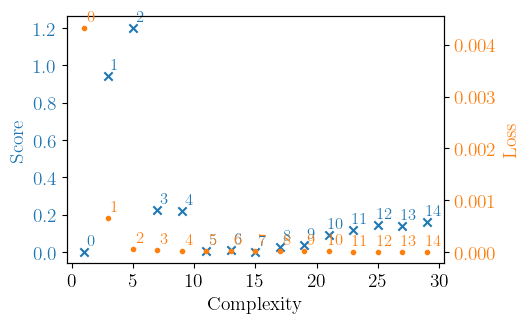

In [40]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../Img/413/Score_Loss_Complexity.png')
plt.savefig('../Img/413/Score_Loss_Complexity.pdf')
plt.savefig('../Img/413/Score_Loss_Complexity.svg')
plt.show()


In [41]:
choose=1
choose_2=4
choose_3=9

exp=model_phi.sympy(choose)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_2=model_phi.sympy(choose_2)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_3=model_phi.sympy(choose_3)*(max_cols_phi-min_cols_phi)+min_cols_phi

In [42]:
sympy.expand(exp)


35.3287124633789*x0**2 - 0.417016446590424

In [43]:
sympy.expand(exp_2)


-208.132591330547*x0**2/(x0**2 - 5.6277323) - 0.417016446590424

In [44]:
sympy.expand(exp_3)


-42.2831765775375*x0**7 + 48.3951780828094*x0**6 + 36.2804856414986*x0**2 - 0.417016446590424

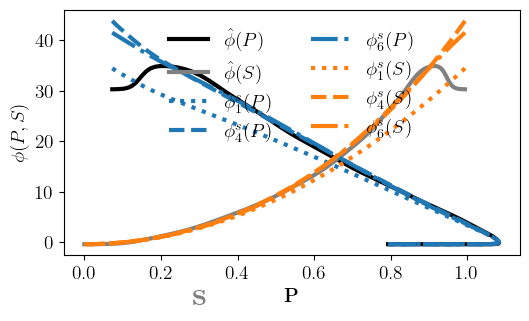

In [45]:
# symb1=model_phi.predict(tf.concat([p, s],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(tf.concat([p, s],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(tf.concat([p, s],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p, phi_pred,linewidth=3, color='black', label='$\hat{\phi}(P)$')
plt.plot(s, phi_pred,linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p, symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_1(P)$')
plt.plot(p, symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_4(P)$')
plt.plot(p, symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_6(P)$')
plt.plot(s, symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_1(S)$')
plt.plot(s, symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_4(S)$')
plt.plot(s, symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_6(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel(r'$\mathbf{P}$', fontsize=14, color='black')
plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/413/Result_phi_s.png')
plt.savefig('../Img/413/Result_phi_s.pdf')
plt.savefig('../Img/413/Result_phi_s.svg')
plt.show()


In [46]:
Nt=10000
P_symb_1=np.zeros(Nt)
P_symb_2=np.zeros(Nt)
P_symb_3=np.zeros(Nt)
S_symb_1=np.zeros(Nt)
S_symb_2=np.zeros(Nt)
S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_1[0]=P_symb_2[0]=P_symb_3[0]=np.mean(uu0) #Initial conditions
S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PS=tf.concat([tf.convert_to_tensor(P_symb_1[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_1[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_1[i]=P_symb_1[i-1]+(model_phi.predict(PS[:,1:2],choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi)*P_symb_1[i-1]*dt
    S_symb_1[i]=S_symb_1[i-1]-P_symb_3[i-1]*S_symb_1[i-1]*tf.exp(lnv[0:1])*dt

    PS=tf.concat([tf.convert_to_tensor(P_symb_2[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_2[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_2[i]=P_symb_2[i-1]+(model_phi.predict(PS[:,1:2],choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi)*P_symb_2[i-1]*dt
    S_symb_2[i]=S_symb_2[i-1]-P_symb_2[i-1]*S_symb_2[i-1]*tf.exp(lnv[0:1])*dt

    PS=tf.concat([tf.convert_to_tensor(P_symb_3[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_3[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_3[i]=P_symb_3[i-1]+(model_phi.predict(PS[:,1:2],choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi)*P_symb_3[i-1]*dt
    S_symb_3[i]=S_symb_3[i-1]-P_symb_3[i-1]*S_symb_3[i-1]*tf.exp(lnv[0:1])*dt

    T_symb[i]=T_symb[i-1]+dt

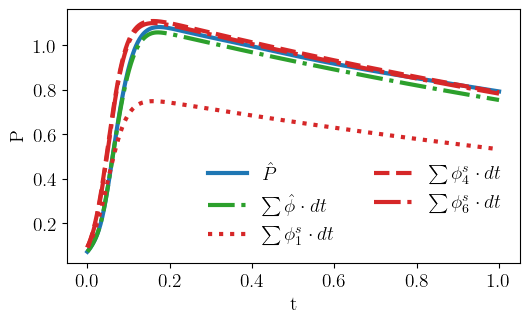

In [47]:
plt.plot(T_star_tf, p, linewidth=3, label='$\hat{P}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_1 \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_4 \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{6} \cdot dt$')



plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/413/Result_int_s_p.png')
plt.savefig('../Img/413/Result_int_s_p.pdf')
plt.savefig('../Img/413/Result_int_s_p.svg')
plt.show()

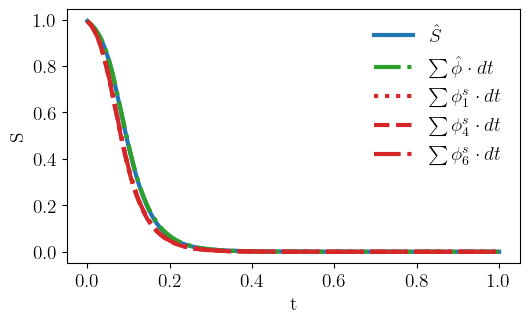

In [48]:
plt.plot(T_star_tf, s, linewidth=3, label='$\hat{S}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, S_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, S_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_1 \cdot dt$')
plt.plot(T_symb, S_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_4 \cdot dt$')
plt.plot(T_symb, S_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{6} \cdot dt$')



plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 1))
plt.xlabel('t', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/413/Result_int_s_s.png')
plt.savefig('../Img/413/Result_int_s_s.pdf')
plt.savefig('../Img/413/Result_int_s_s.svg')
plt.show()

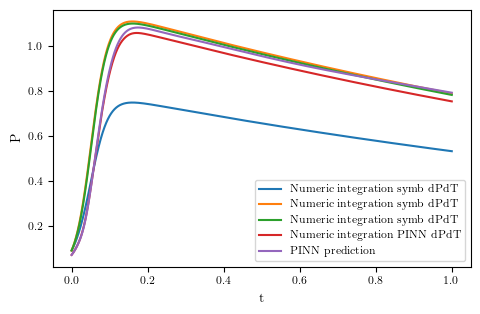

In [49]:
plt.plot(T_symb, P_symb_1, label='Numeric integration symb dPdT')
plt.plot(T_symb, P_symb_2, label='Numeric integration symb dPdT')
plt.plot(T_symb, P_symb_3, label='Numeric integration symb dPdT')


plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

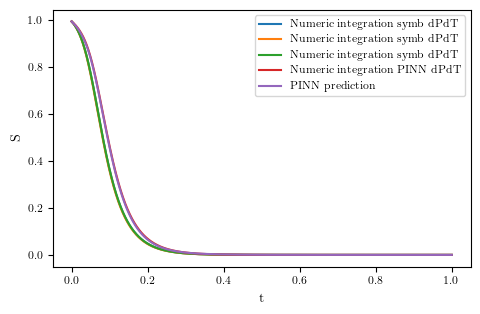

In [50]:
plt.plot(T_symb, S_symb_1, label='Numeric integration symb dPdT')
plt.plot(T_symb, S_symb_2, label='Numeric integration symb dPdT')
plt.plot(T_symb, S_symb_3, label='Numeric integration symb dPdT')

plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()

In [51]:
Nt=10000
P_symb_m=np.zeros(Nt)
S_symb_m=np.zeros(Nt)
T_symb_m=np.zeros(Nt)
dt=0.0001
m=np.array(31.0)
a=np.array(33.0)
b=np.array(0.4)
P_symb_m[0]=np.mean(uu0) #Initial conditions
S_symb_m[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0.04

for i in range(1,Nt):
    # PS=tf.concat([tf.convert_to_tensor(P_symb_m[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb_m[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb_m[i]=P_symb_m[i-1]+(a*S_symb_m[i-1]-b)*P_symb_m[i-1]*dt
    S_symb_m[i]=S_symb_m[i-1]-P_symb_m[i-1]*S_symb_m[i-1]*m*dt


    T_symb_m[i]=T_symb_m[i-1]+dt

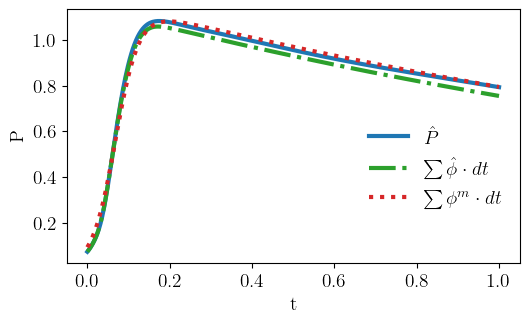

In [52]:
plt.plot(T_star_tf, p, linewidth=3, label='$\hat{P}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb_m, P_symb_m, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^m \cdot dt$')



plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.6))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/413/Result_int_man.png')
plt.savefig('../Img/413/Result_int_man.pdf')
plt.savefig('../Img/413/Result_int_man.svg')
plt.show()

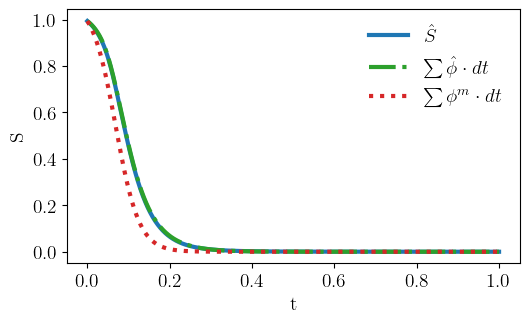

In [53]:
plt.plot(T_star_tf, s, linewidth=3, label='$\hat{S}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, S_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb_m, S_symb_m, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^m \cdot dt$')



plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 1))
plt.xlabel('t', fontsize=14)
plt.ylabel('S', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/413/Result_int_s_man.png')
plt.savefig('../Img/413/Result_int_s_man.pdf')
plt.savefig('../Img/413/Result_int_s_man.svg')
plt.show()

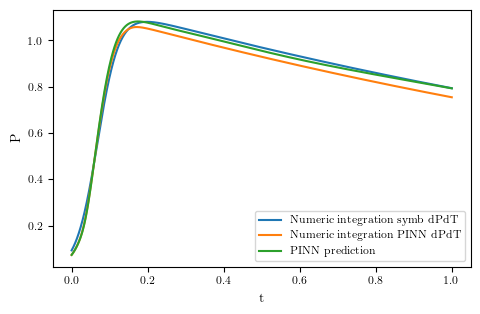

In [54]:
plt.plot(T_symb_m, P_symb_m, label='Numeric integration symb dPdT')


plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

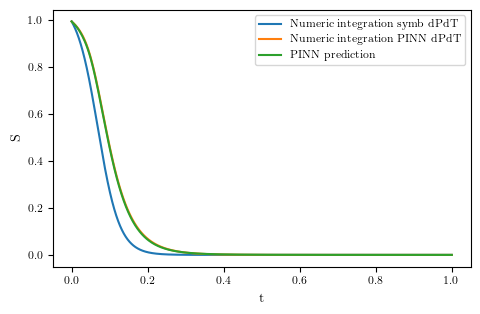

In [55]:
plt.plot(T_symb_m, S_symb_m, label='Numeric integration symb dPdT')

plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()